# Import

In [0]:
%pip install --upgrade pip
%pip install "pydantic<2" spacy
%pip install langdetect
%pip install vaderSentiment

Python interpreter will be restarted.
  Attempting uninstall: pip
    Found existing installation: pip 21.2.4
    Uninstalling pip-21.2.4:
      Successfully uninstalled pip-21.2.4
Python interpreter will be restarted.
Python interpreter will be restarted.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 186.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 147.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 152.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 63.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Not uninstalling

In [0]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 24.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql.functions import sum, max, min

from langdetect import detect

import re
from pyspark.sql.functions import udf, explode, split, to_date, when, col, count, lag, datediff, length, avg
from pyspark.sql.types import StringType, FloatType
from pyspark.sql.window import Window

import spacy

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import time

In [0]:
#!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv

#dataset = pd.read_csv('/databricks/driver/bitcoin_tweets.csv', delimiter=",")

#spark_df = spark.createDataFrame(dataset)
#spark_df.write.saveAsTable("bitcoin_tweets")

In [0]:
spark_df = spark.read.format("delta").load("dbfs:/user/hive/warehouse/bitcoin_tweets")

# EDA

## Taking a look

In [0]:
display(spark_df.limit(5))

id,user,fullname,url,timestamp,replies,likes,retweets,text
1.1329770553003008E18,KamdemAbdiel,Abdiel kamdem,null,2019-05-27 11:49:14+00,0.0,0.0,0.0,È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉRISENT BITCOIN EN 2019 https://t.co/yCsQMvRnyS
1.13297707340273664E18,bitcointe,Bitcointe,null,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano: Digitize Currencies; EOS https://t.co/1kTKqKEBlS 6500% ROI; AT&T Bitcoin Bill Pay https://t.co/eQCwOXKHK0 | Cardano (ADA) 🌏📢😎🤑💵 | #FolloForFolloBack #follo4folloback #followforfollow #bitcointe #cryptocurrency
1.13297702389313958E18,3eyedbran,Bran - 3 Eyed Raven,null,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasn't caught in the stream ! bitcoin
1.13297708908955635E18,DetroitCrypto,J. Scardina,null,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices! BTC: $8721.99 USD ETH: $266.62 USD LTC: $114.03 USD BCH: $432.02 USD XLM: $0.133 USD DOGE: $ 0.00314 USD NEO: $12.04 USD XRP: $0.4092 USD CANN: $0.001482 USD EMC2: $0.1198 USD XMR: $94.65 USD BTG: $24.31 USD
1.13297709234019123E18,mmursaleen72,Muhammad Mursaleen,null,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv (Nosar Baz): BITCOIN Is An Asset & NOT A Currency. https://t.co/FJru1ooxSM https://t.co/fYBX4H6r6r https://t.co/xZSjmZ0h3K https://t.co/v7GRFIQG7w https://t.co/Oq5hQt5hNn


## Shape

In [0]:
num_rows = spark_df.count()  # # of rows
num_cols = len(spark_df.columns)  # # of cols

print(f"DataFrame has {num_rows} rows e {num_cols} cols.")

DataFrame has 100001 rows e 9 cols.


## Duplicates?

In [0]:
# Group by all columns and count occurrences
df_duplicates = (
    spark_df.groupBy(*spark_df.columns)
    .agg(count("*").alias("count"))  # Count occurrences of each unique row
    .filter(col("count") > 1)  # Keep only duplicate rows
)

# Show duplicate rows with their count
df_duplicates.show()

+---+----+--------+---+---------+-------+-----+--------+----+-----+
| id|user|fullname|url|timestamp|replies|likes|retweets|text|count|
+---+----+--------+---+---------+-------+-----+--------+----+-----+
+---+----+--------+---+---------+-------+-----+--------+----+-----+



## Missing values

In [0]:
# Compute missing values count for each column
missing_values = spark_df.select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in spark_df.columns]
)

# Show the number of missing values per column
missing_values.show()

+---+----+--------+-----+---------+-------+-----+--------+----+
| id|user|fullname|  url|timestamp|replies|likes|retweets|text|
+---+----+--------+-----+---------+-------+-----+--------+----+
|  0|   0|       3|96679|        0|      0|    0|       0|   0|
+---+----+--------+-----+---------+-------+-----+--------+----+



## Incosistent data?

In [0]:
# are # of likes and replies reasonable for a human being and not a bot?
spark_df.describe(["likes", "replies"]).show()

+-------+-----------------+------------------+
|summary|            likes|           replies|
+-------+-----------------+------------------+
|  count|           100001|            100001|
|   mean|7.209347906520935|0.8356216437835622|
| stddev|95.27780194261304|14.136569579845233|
|    min|              0.0|               0.0|
|    max|          14470.0|            2104.0|
+-------+-----------------+------------------+



In [0]:
# in how many days 14470 as max?

# Get the first and last date
date_range = spark_df.select(min("timestamp").alias("start_date"), max("timestamp").alias("end_date"))

# Compute the difference in days
date_diff = date_range.withColumn("days_difference", datediff(col("end_date"), col("start_date")))

# Show the result
date_diff.show()

+--------------------+--------------------+---------------+
|          start_date|            end_date|days_difference|
+--------------------+--------------------+---------------+
|2009-01-11 03:33:...|2019-05-27 12:21:...|           3788|
+--------------------+--------------------+---------------+



In [0]:
# are there any very short tweet?
spark_df.filter(length(col("text")) < 5).show()

+--------------------+---------------+--------------------+----+--------------------+-------+-----+--------+--------+
|                  id|           user|            fullname| url|           timestamp|replies|likes|retweets|    text|
+--------------------+---------------+--------------------+----+--------------------+-------+-----+--------+--------+
|1.132977185910870...|    sigizmundo8|           sigizmund|null|2019-05-27 11:49:...|    0.0|  0.0|     0.0|  🤣🤣🤣|
|1.126826102956204...|  thabubbajames|        Crypto Bubba|null|2019-05-10 10:27:...|    0.0|  0.0|     0.0|    😂😂|
|1.127004033162588...|    hao32927291|                 hao|null|2019-05-10 22:14:...|    0.0|  0.0|     0.0|    nice|
|1.126890051386912...|         TI__Ed|                TIED|null|2019-05-10 14:41:...|    0.0|  0.0|     0.0|     BTC|
|1.127004265858224E18|         birmas|              birmas|null|2019-05-10 22:15:...|    0.0|  0.0|     0.0|      👍|
|1.127045801769930...|       mironyan|          Yavruyan E|nul

# Preprocessing

## Remove unnecessary cols

In [0]:
columns_to_keep = ["timestamp", "replies", "likes", "text"]
spark_df = spark_df.select(columns_to_keep)

In [0]:
# cleaning function
def clean_text(text: str) -> str:
    if not text:
        return ""
    # Remove URL (ex. http://, https://, www.)
    text = re.sub(r"http\S+|www\S+", "", text)
    # Remove mention
    text = re.sub(r"@\S+", "", text)
    # Remove '#' keeping the word (ex. "#happy" become "happy")
    text = re.sub(r"#", "", text)
    # Remove special characters
    text = re.sub(r"[^A-Za-z0-9\s]+", "", text)
    # Removing spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Register function as udf
clean_text_udf = udf(clean_text, StringType())

# apply cleaning, the result will be in a new col named clean_text
spark_df = spark_df.withColumn("clean_text", clean_text_udf(col("text")))

# filter too short tweet
spark_df = spark_df.filter(length(col("clean_text")) >= 5)

# Show examples
display(spark_df.select("text", "clean_text").limit(10))

text,clean_text
È appena uscito un nuovo video! LES CRYPTOMONNAIES QUI PULVÉRISENT BITCOIN EN 2019 https://t.co/yCsQMvRnyS,appena uscito un nuovo video LES CRYPTOMONNAIES QUI PULVRISENT BITCOIN EN 2019
Cardano: Digitize Currencies; EOS https://t.co/1kTKqKEBlS 6500% ROI; AT&T Bitcoin Bill Pay https://t.co/eQCwOXKHK0 | Cardano (ADA) 🌏📢😎🤑💵 | #FolloForFolloBack #follo4folloback #followforfollow #bitcointe #cryptocurrency,Cardano Digitize Currencies EOS 6500 ROI ATampT Bitcoin Bill Pay Cardano ADA FolloForFolloBack follo4folloback followforfollow bitcointe cryptocurrency
Another Test tweet that wasn't caught in the stream ! bitcoin,Another Test tweet that wasnt caught in the stream bitcoin
Current Crypto Prices! BTC: $8721.99 USD ETH: $266.62 USD LTC: $114.03 USD BCH: $432.02 USD XLM: $0.133 USD DOGE: $ 0.00314 USD NEO: $12.04 USD XRP: $0.4092 USD CANN: $0.001482 USD EMC2: $0.1198 USD XMR: $94.65 USD BTG: $24.31 USD,Current Crypto Prices BTC 872199 USD ETH 26662 USD LTC 11403 USD BCH 43202 USD XLM 0133 USD DOGE 000314 USD NEO 1204 USD XRP 04092 USD CANN 0001482 USD EMC2 01198 USD XMR 9465 USD BTG 2431 USD
Spiv (Nosar Baz): BITCOIN Is An Asset & NOT A Currency. https://t.co/FJru1ooxSM https://t.co/fYBX4H6r6r https://t.co/xZSjmZ0h3K https://t.co/v7GRFIQG7w https://t.co/Oq5hQt5hNn,Spiv Nosar Baz BITCOIN Is An Asset amp NOT A Currency
"#btc inceldiği yerden kopsun bakalım 17:00 ye kadar bir hareket bekliyorum, yukarı yönlü olur umarın sanırım inşallah yani 😁 https://t.co/pIMyKfNtc8",btc inceldii yerden kopsun bakalm 1700 ye kadar bir hareket bekliyorum yukar ynl olur umarn sanrm inallah yani
@nwoodfine We have been building on the real #bitcoin SV. What have you been building on broken BTC?,We have been building on the real bitcoin SV What have you been building on broken BTC
"@pedronauck como investidor, vc é um ótimo dev. Sorte q eu comprei os BTC, subiu a poha toda :o",como investidor vc um timo dev Sorte q eu comprei os BTC subiu a poha toda o
"CHANGE IS COMING...GET READY!!! Boom, Another [CB] Jab, Nothing Can Stop This! Globalism at its end stage, [CB] push to make a one world govt. coming to an end. The People Are Taking the Lead, & Leaders Will Have to Follow the Majority!!! WWG1WGQ!!! https://t.co/tAjFwxnWD4",CHANGE IS COMINGGET READY Boom Another CB Jab Nothing Can Stop This Globalism at its end stage CB push to make a one world govt coming to an end The People Are Taking the Lead amp Leaders Will Have to Follow the Majority WWG1WGQ
"One of the useful articles of Stefan; here is the guide, you can run a @LTOnetwork node on Alibaba Cloud. https://t.co/iJ9rlkaabt #ltonetwork $lto #Eth #xrpcommmunity #crypto #xlm #xrp #blockchain #xrpcommmunity #eos #xmr #trx #ltc #enjin #ethereum #bitcoin",One of the useful articles of Stefan here is the guide you can run a node on Alibaba Cloud ltonetwork lto Eth xrpcommmunity crypto xlm xrp blockchain xrpcommmunity eos xmr trx ltc enjin ethereum bitcoin


## Filter english tweets

In [0]:
# function
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

# Register as udf
lang_udf = udf(detect_language, StringType())

# apply language detection on "clean_text"
spark_df = spark_df.withColumn("language", lang_udf(col("clean_text")))

# filter en tweets
spark_df = spark_df.filter(col("language") == "en")

# remove language col
spark_df = spark_df.drop("language")

# check
display(spark_df.limit(10))

timestamp,replies,likes,text,clean_text
2019-05-27 11:49:18+00,0.0,0.0,Cardano: Digitize Currencies; EOS https://t.co/1kTKqKEBlS 6500% ROI; AT&T Bitcoin Bill Pay https://t.co/eQCwOXKHK0 | Cardano (ADA) 🌏📢😎🤑💵 | #FolloForFolloBack #follo4folloback #followforfollow #bitcointe #cryptocurrency,Cardano Digitize Currencies EOS 6500 ROI ATampT Bitcoin Bill Pay Cardano ADA FolloForFolloBack follo4folloback followforfollow bitcointe cryptocurrency
2019-05-27 11:49:06+00,0.0,2.0,Another Test tweet that wasn't caught in the stream ! bitcoin,Another Test tweet that wasnt caught in the stream bitcoin
2019-05-27 11:49:22+00,0.0,0.0,Current Crypto Prices! BTC: $8721.99 USD ETH: $266.62 USD LTC: $114.03 USD BCH: $432.02 USD XLM: $0.133 USD DOGE: $ 0.00314 USD NEO: $12.04 USD XRP: $0.4092 USD CANN: $0.001482 USD EMC2: $0.1198 USD XMR: $94.65 USD BTG: $24.31 USD,Current Crypto Prices BTC 872199 USD ETH 26662 USD LTC 11403 USD BCH 43202 USD XLM 0133 USD DOGE 000314 USD NEO 1204 USD XRP 04092 USD CANN 0001482 USD EMC2 01198 USD XMR 9465 USD BTG 2431 USD
2019-05-27 11:49:23+00,0.0,0.0,Spiv (Nosar Baz): BITCOIN Is An Asset & NOT A Currency. https://t.co/FJru1ooxSM https://t.co/fYBX4H6r6r https://t.co/xZSjmZ0h3K https://t.co/v7GRFIQG7w https://t.co/Oq5hQt5hNn,Spiv Nosar Baz BITCOIN Is An Asset amp NOT A Currency
2019-05-27 11:49:25+00,0.0,0.0,@nwoodfine We have been building on the real #bitcoin SV. What have you been building on broken BTC?,We have been building on the real bitcoin SV What have you been building on broken BTC
2019-05-27 11:49:32+00,0.0,0.0,"CHANGE IS COMING...GET READY!!! Boom, Another [CB] Jab, Nothing Can Stop This! Globalism at its end stage, [CB] push to make a one world govt. coming to an end. The People Are Taking the Lead, & Leaders Will Have to Follow the Majority!!! WWG1WGQ!!! https://t.co/tAjFwxnWD4",CHANGE IS COMINGGET READY Boom Another CB Jab Nothing Can Stop This Globalism at its end stage CB push to make a one world govt coming to an end The People Are Taking the Lead amp Leaders Will Have to Follow the Majority WWG1WGQ
2019-05-27 11:49:19+00,0.0,14.0,"One of the useful articles of Stefan; here is the guide, you can run a @LTOnetwork node on Alibaba Cloud. https://t.co/iJ9rlkaabt #ltonetwork $lto #Eth #xrpcommmunity #crypto #xlm #xrp #blockchain #xrpcommmunity #eos #xmr #trx #ltc #enjin #ethereum #bitcoin",One of the useful articles of Stefan here is the guide you can run a node on Alibaba Cloud ltonetwork lto Eth xrpcommmunity crypto xlm xrp blockchain xrpcommmunity eos xmr trx ltc enjin ethereum bitcoin
2019-05-21 16:49:45+00,47.0,81.0,"BTC IS STILL GOING STRONG!! Thus, we are giving away 0.04 BTC and 10 BNB to 2 lucky winners! GIVEAWAY doubles at 250 RT! To enter: Follow us Subscribe https://t.co/XDmlTtX3ie RT #airdrop #bitcoin #ico #cryptocurrency #xrp #ETH #TRX #Binance #ethereum #btc #crypto #bounty https://t.co/pbCOQu3Uzo",BTC IS STILL GOING STRONG Thus we are giving away 004 BTC and 10 BNB to 2 lucky winners GIVEAWAY doubles at 250 RT To enter Follow us Subscribe RT airdrop bitcoin ico cryptocurrency xrp ETH TRX Binance ethereum btc crypto bounty
2019-05-22 12:42:16+00,3.0,2.0,BestMixer has been seized by the Dutch Police / Luxembourg Police and French Police w/ association from Europol. BestMixer was a Bitcoin Mixer/Tumbler. #Cryptocurrency #Bitcoin #BestMixer https://t.co/dXrEY9yAtt,BestMixer has been seized by the Dutch Police Luxembourg Police and French Police w association from Europol BestMixer was a Bitcoin MixerTumbler Cryptocurrency Bitcoin BestMixer
2019-05-27 11:49:30+00,1.0,1.0,Invested my Life Savings into Bitcoin and Ethereum | Vlog #09 https://t.co/CEL0BXw3fs https://t.co/AET16t8a56,Invested my Life Savings into Bitcoin and Ethereum Vlog 09


In [0]:
num_rows = spark_df.count()  # # of rows
num_cols = len(spark_df.columns)  # # of cols

print(f"DataFrame has {num_rows} rows e {num_cols} cols.")

DataFrame has 75125 rows e 4 cols.


# Tweets Sentiment Analysis

## Tokenize & Lemmatize

### Versione vecchia

In [0]:
nlp = spacy.load("en_core_web_sm")

# Define function to tokenize and lemmatize a single text
def tokenize_and_lemmatize(text: str) -> str:
    if not text:
        return ""
    doc = nlp(text)
    lemmatized_words = [
        token.lemma_ if token.is_alpha else token.text
        for token in doc
    ]
    return " ".join(lemmatized_words)

# Convert Spark to Pandas for chunk processing
pdf = spark_df.select("text", "timestamp", "likes", "replies").toPandas()

# Process in chunks
chunk_size = 200
results = []

for i in range(0, len(pdf), chunk_size):
    chunk = pdf.iloc[i:i+chunk_size].copy()
    chunk["lemmatized_text"] = chunk["text"].apply(tokenize_and_lemmatize)
    results.append(chunk)

# Concatenate all processed chunks
lemmatized_df = pd.concat(results, ignore_index=True)

# Convert back to Spark DataFrame
lemmatized_spark_df = spark.createDataFrame(lemmatized_df)

# Save and reload to avoid recomputing this step
lemmatized_spark_df.write.mode("overwrite").parquet("/tmp/lemmatized_tweets")
lemmatized_spark_df = spark.read.parquet("/tmp/lemmatized_tweets")

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                                         |lemmatized_text    

### Versione nuova

In [0]:
# load spacy model
nlp = spacy.load("en_core_web_sm")

# function to tokenize e lemmatize
def tokenize_and_lemmatize(text: str) -> str:
    if not text:
        return ""
    doc = nlp(text)
    # Keep lemma for alfa words, otherwise original token
    lemmatized_words = [token.lemma_ if token.is_alpha else token.text for token in doc]
    return " ".join(lemmatized_words)

# convert df from spark to pandas to use chunks
pdf = spark_df.select("clean_text", "timestamp", "likes", "replies").toPandas()

# Process data in chunks
chunk_size = 200
results = []

for i in range(0, len(pdf), chunk_size):
    chunk = pdf.iloc[i:i+chunk_size].copy()
    # Apply token and lemmat
    chunk["lemmatized_text"] = chunk["clean_text"].apply(tokenize_and_lemmatize)
    results.append(chunk)

# concatenate all chunks
lemmatized_df = pd.concat(results, ignore_index=True)

# reconvert to df spark
lemmatized_spark_df = spark.createDataFrame(lemmatized_df)

# save and load
lemmatized_spark_df.write.mode("overwrite").parquet("/tmp/lemmatized_tweets")
lemmatized_spark_df = spark.read.parquet("/tmp/lemmatized_tweets")

# check
display(lemmatized_spark_df.limit(10))

clean_text,timestamp,likes,replies,lemmatized_text
Cardano Digitize Currencies EOS 6500 ROI ATampT Bitcoin Bill Pay Cardano ADA FolloForFolloBack follo4folloback followforfollow bitcointe cryptocurrency,2019-05-27 11:49:18+00,0.0,0.0,Cardano Digitize Currencies EOS 6500 ROI atampt Bitcoin Bill Pay Cardano ADA FolloForFolloBack follo4folloback followforfollow bitcointe cryptocurrency
Another Test tweet that wasnt caught in the stream bitcoin,2019-05-27 11:49:06+00,2.0,0.0,another Test tweet that be not catch in the stream bitcoin
Current Crypto Prices BTC 872199 USD ETH 26662 USD LTC 11403 USD BCH 43202 USD XLM 0133 USD DOGE 000314 USD NEO 1204 USD XRP 04092 USD CANN 0001482 USD EMC2 01198 USD XMR 9465 USD BTG 2431 USD,2019-05-27 11:49:22+00,0.0,0.0,current Crypto price BTC 872199 usd ETH 26662 USD LTC 11403 USD BCH 43202 USD XLM 0133 USD doge 000314 usd NEO 1204 USD XRP 04092 USD CANN 0001482 USD EMC2 01198 USD XMR 9465 USD BTG 2431 usd
Spiv Nosar Baz BITCOIN Is An Asset amp NOT A Currency,2019-05-27 11:49:23+00,0.0,0.0,Spiv Nosar Baz BITCOIN be an Asset amp not a currency
We have been building on the real bitcoin SV What have you been building on broken BTC,2019-05-27 11:49:25+00,0.0,0.0,we have be build on the real bitcoin sv what have you be build on broken BTC
CHANGE IS COMINGGET READY Boom Another CB Jab Nothing Can Stop This Globalism at its end stage CB push to make a one world govt coming to an end The People Are Taking the Lead amp Leaders Will Have to Follow the Majority WWG1WGQ,2019-05-27 11:49:32+00,0.0,0.0,change be COMINGGET READY Boom another cb Jab nothing can stop this Globalism at its end stage cb push to make a one world govt come to an end the People be take the Lead amp leader will have to follow the Majority WWG1WGQ
One of the useful articles of Stefan here is the guide you can run a node on Alibaba Cloud ltonetwork lto Eth xrpcommmunity crypto xlm xrp blockchain xrpcommmunity eos xmr trx ltc enjin ethereum bitcoin,2019-05-27 11:49:19+00,14.0,0.0,one of the useful article of Stefan here be the guide you can run a node on Alibaba Cloud ltonetwork lto Eth xrpcommmunity crypto xlm xrp blockchain xrpcommmunity eos xmr trx ltc enjin ethereum bitcoin
BTC IS STILL GOING STRONG Thus we are giving away 004 BTC and 10 BNB to 2 lucky winners GIVEAWAY doubles at 250 RT To enter Follow us Subscribe RT airdrop bitcoin ico cryptocurrency xrp ETH TRX Binance ethereum btc crypto bounty,2019-05-21 16:49:45+00,81.0,47.0,BTC be still go STRONG thus we be give away 004 BTC and 10 BNB to 2 lucky winner giveaway double at 250 RT to enter Follow we Subscribe RT airdrop bitcoin ico cryptocurrency xrp ETH TRX Binance ethereum btc crypto bounty
BestMixer has been seized by the Dutch Police Luxembourg Police and French Police w association from Europol BestMixer was a Bitcoin MixerTumbler Cryptocurrency Bitcoin BestMixer,2019-05-22 12:42:16+00,2.0,3.0,BestMixer have be seize by the Dutch Police Luxembourg Police and French Police w association from Europol BestMixer be a Bitcoin MixerTumbler Cryptocurrency Bitcoin BestMixer
Invested my Life Savings into Bitcoin and Ethereum Vlog 09,2019-05-27 11:49:30+00,1.0,1.0,invest my life Savings into Bitcoin and Ethereum Vlog 09


In [0]:
# check
display(lemmatized_spark_df.limit(10))

clean_text,timestamp,likes,replies,lemmatized_text
Cardano Digitize Currencies EOS 6500 ROI ATampT Bitcoin Bill Pay Cardano ADA FolloForFolloBack follo4folloback followforfollow bitcointe cryptocurrency,2019-05-27 11:49:18+00,0.0,0.0,Cardano Digitize Currencies EOS 6500 ROI atampt Bitcoin Bill Pay Cardano ADA FolloForFolloBack follo4folloback followforfollow bitcointe cryptocurrency
Another Test tweet that wasnt caught in the stream bitcoin,2019-05-27 11:49:06+00,2.0,0.0,another Test tweet that be not catch in the stream bitcoin
Current Crypto Prices BTC 872199 USD ETH 26662 USD LTC 11403 USD BCH 43202 USD XLM 0133 USD DOGE 000314 USD NEO 1204 USD XRP 04092 USD CANN 0001482 USD EMC2 01198 USD XMR 9465 USD BTG 2431 USD,2019-05-27 11:49:22+00,0.0,0.0,current Crypto price BTC 872199 usd ETH 26662 USD LTC 11403 USD BCH 43202 USD XLM 0133 USD doge 000314 usd NEO 1204 USD XRP 04092 USD CANN 0001482 USD EMC2 01198 USD XMR 9465 USD BTG 2431 usd
Spiv Nosar Baz BITCOIN Is An Asset amp NOT A Currency,2019-05-27 11:49:23+00,0.0,0.0,Spiv Nosar Baz BITCOIN be an Asset amp not a currency
We have been building on the real bitcoin SV What have you been building on broken BTC,2019-05-27 11:49:25+00,0.0,0.0,we have be build on the real bitcoin sv what have you be build on broken BTC
CHANGE IS COMINGGET READY Boom Another CB Jab Nothing Can Stop This Globalism at its end stage CB push to make a one world govt coming to an end The People Are Taking the Lead amp Leaders Will Have to Follow the Majority WWG1WGQ,2019-05-27 11:49:32+00,0.0,0.0,change be COMINGGET READY Boom another cb Jab nothing can stop this Globalism at its end stage cb push to make a one world govt come to an end the People be take the Lead amp leader will have to follow the Majority WWG1WGQ
One of the useful articles of Stefan here is the guide you can run a node on Alibaba Cloud ltonetwork lto Eth xrpcommmunity crypto xlm xrp blockchain xrpcommmunity eos xmr trx ltc enjin ethereum bitcoin,2019-05-27 11:49:19+00,14.0,0.0,one of the useful article of Stefan here be the guide you can run a node on Alibaba Cloud ltonetwork lto Eth xrpcommmunity crypto xlm xrp blockchain xrpcommmunity eos xmr trx ltc enjin ethereum bitcoin
BTC IS STILL GOING STRONG Thus we are giving away 004 BTC and 10 BNB to 2 lucky winners GIVEAWAY doubles at 250 RT To enter Follow us Subscribe RT airdrop bitcoin ico cryptocurrency xrp ETH TRX Binance ethereum btc crypto bounty,2019-05-21 16:49:45+00,81.0,47.0,BTC be still go STRONG thus we be give away 004 BTC and 10 BNB to 2 lucky winner giveaway double at 250 RT to enter Follow we Subscribe RT airdrop bitcoin ico cryptocurrency xrp ETH TRX Binance ethereum btc crypto bounty
BestMixer has been seized by the Dutch Police Luxembourg Police and French Police w association from Europol BestMixer was a Bitcoin MixerTumbler Cryptocurrency Bitcoin BestMixer,2019-05-22 12:42:16+00,2.0,3.0,BestMixer have be seize by the Dutch Police Luxembourg Police and French Police w association from Europol BestMixer be a Bitcoin MixerTumbler Cryptocurrency Bitcoin BestMixer
Invested my Life Savings into Bitcoin and Ethereum Vlog 09,2019-05-27 11:49:30+00,1.0,1.0,invest my life Savings into Bitcoin and Ethereum Vlog 09


## VADER

### Versione vecchia

In [0]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a UDF to get the VADER compound score
def vader_sentiment(text: str) -> float:
    return analyzer.polarity_scores(text)["compound"] if text else 0.0

# Register UDF in Spark
vader_udf = udf(vader_sentiment, FloatType())

# Apply sentiment score
lemmatized_spark_df = lemmatized_spark_df.withColumn(
    "sentiment_score", vader_udf(col("lemmatized_text"))
)

# Classify sentiment based on compound score
lemmatized_spark_df = lemmatized_spark_df.withColumn(
    "sentiment_category",
    when(col("sentiment_score") > 0.05, "Positive")
    .when(col("sentiment_score") < -0.05, "Negative")
    .otherwise("Neutral")
)

# Save
lemmatized_spark_df.write.mode("overwrite").parquet("/tmp/sentiment_tweets")
lemmatized_spark_df = spark.read.parquet("/tmp/sentiment_tweets")

### Versione nuova

In [0]:
# initialize VADER
analyzer = SentimentIntensityAnalyzer()

# function to compound
def vader_sentiment(text: str) -> float:
    if not text:
        return 0.0
    return analyzer.polarity_scores(text)["compound"]

# register udf in spark
vader_udf = udf(vader_sentiment, FloatType())

# apply sentiment analysis
lemmatized_spark_df = lemmatized_spark_df.withColumn("sentiment_score", vader_udf(col("lemmatized_text")))

# classify by compound:
# > 0.05 = Positive, < -0.05 = Negative, otherwise Neutral
lemmatized_spark_df = lemmatized_spark_df.withColumn(
    "sentiment_category",
    when(col("sentiment_score") > 0.05, "Positive")
    .when(col("sentiment_score") < -0.05, "Negative")
    .otherwise("Neutral")
)

# Check
display(lemmatized_spark_df.select("lemmatized_text", "sentiment_score", "sentiment_category").limit(10))

lemmatized_text,sentiment_score,sentiment_category
Cardano Digitize Currencies EOS 6500 ROI atampt Bitcoin Bill Pay Cardano ADA FolloForFolloBack follo4folloback followforfollow bitcointe cryptocurrency,-0.1027,Negative
another Test tweet that be not catch in the stream bitcoin,0.0,Neutral
current Crypto price BTC 872199 usd ETH 26662 USD LTC 11403 USD BCH 43202 USD XLM 0133 USD doge 000314 usd NEO 1204 USD XRP 04092 USD CANN 0001482 USD EMC2 01198 USD XMR 9465 USD BTG 2431 usd,0.0,Neutral
Spiv Nosar Baz BITCOIN be an Asset amp not a currency,0.3612,Positive
we have be build on the real bitcoin sv what have you be build on broken BTC,-0.4767,Negative
change be COMINGGET READY Boom another cb Jab nothing can stop this Globalism at its end stage cb push to make a one world govt come to an end the People be take the Lead amp leader will have to follow the Majority WWG1WGQ,0.6275,Positive
one of the useful article of Stefan here be the guide you can run a node on Alibaba Cloud ltonetwork lto Eth xrpcommmunity crypto xlm xrp blockchain xrpcommmunity eos xmr trx ltc enjin ethereum bitcoin,0.4404,Positive
BTC be still go STRONG thus we be give away 004 BTC and 10 BNB to 2 lucky winner giveaway double at 250 RT to enter Follow we Subscribe RT airdrop bitcoin ico cryptocurrency xrp ETH TRX Binance ethereum btc crypto bounty,0.8918,Positive
BestMixer have be seize by the Dutch Police Luxembourg Police and French Police w association from Europol BestMixer be a Bitcoin MixerTumbler Cryptocurrency Bitcoin BestMixer,0.0,Neutral
invest my life Savings into Bitcoin and Ethereum Vlog 09,0.0,Neutral


In [0]:
# Save
lemmatized_spark_df.write.mode("overwrite").parquet("/tmp/sentiment_tweets")
lemmatized_spark_df = spark.read.parquet("/tmp/sentiment_tweets")

# Time series: consensus per day

## Versione vecchia

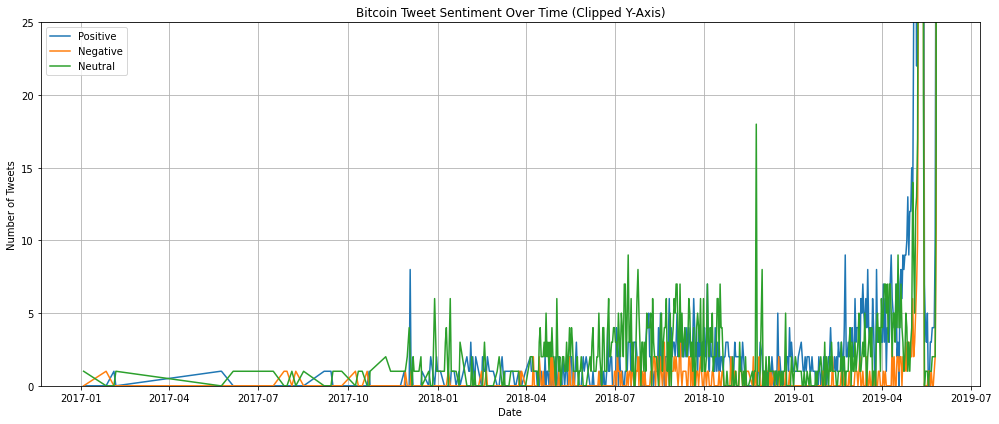

In [0]:
# Extract date from timestamp
lemmatized_spark_df = lemmatized_spark_df.withColumn("date", to_date("timestamp"))

# Filter only realistic tweet dates (e.g., after 2017)
lemmatized_spark_df = lemmatized_spark_df.filter(col("date") >= "2017-01-01")

# Aggregate sentiment per day
daily_sentiment = (
    lemmatized_spark_df
    .groupBy("date", "sentiment_category")
    .agg(count("*").alias("count"))
    .orderBy("date")
)

# Convert to Pandas for visualization
daily_sentiment_pd = daily_sentiment.toPandas()

# Pivot for plotting
pivot_df = daily_sentiment_pd.pivot(index="date", columns="sentiment_category", values="count").fillna(0)

# Plotting with Y-axis limit to avoid outlier flattening
plt.figure(figsize=(14, 6))
for sentiment in ["Positive", "Negative", "Neutral"]:
    if sentiment in pivot_df.columns:
        plt.plot(pivot_df.index, pivot_df[sentiment], label=sentiment)

plt.title("Bitcoin Tweet Sentiment Over Time (Clipped Y-Axis)")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.ylim(0, 25)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

## Versione nuova

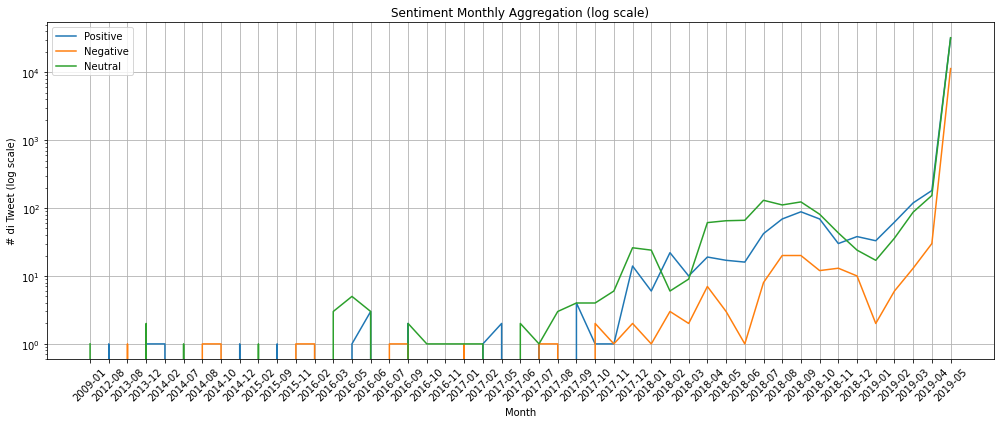

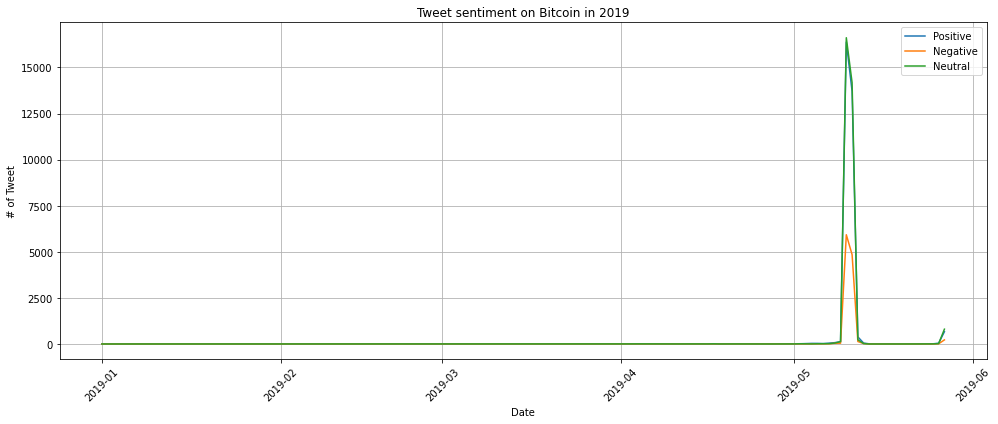

In [0]:
# Extract date from timestamp col
lemmatized_spark_df = lemmatized_spark_df.withColumn("date", to_date("timestamp"))

# Aggregate # tweet per day and sentiment
daily_sentiment = (
    lemmatized_spark_df
    .groupBy("date", "sentiment_category")
    .agg(count("*").alias("count"))
    .orderBy("date")
)

# Convert in pandas to facilitate viz
daily_sentiment_pd = daily_sentiment.toPandas()

# -------------------------------
# Plot 1: Monthly aggregation
# -------------------------------

# Ensure date is in datetime
daily_sentiment_pd['date'] = pd.to_datetime(daily_sentiment_pd['date'])

# Create a new col month, in format es. "2019-01"
daily_sentiment_pd['month'] = daily_sentiment_pd['date'].dt.to_period('M')

# Group by month and sentiment category
monthly_sentiment = daily_sentiment_pd.groupby(['month', 'sentiment_category']).agg({'count': 'sum'}).reset_index()

# Create a pivot to have sentiment categories as cols
pivot_monthly = monthly_sentiment.pivot(index="month", columns="sentiment_category", values="count").fillna(0)

# Plot: for each sentiment, y in log scale
plt.figure(figsize=(14, 6))
for sentiment in ["Positive", "Negative", "Neutral"]:
    if sentiment in pivot_monthly.columns:
        plt.plot(pivot_monthly.index.astype(str), pivot_monthly[sentiment], label=sentiment)
plt.yscale("log")
plt.title("Sentiment Monthly Aggregation (log scale)")
plt.xlabel("Month")
plt.ylabel("# di Tweet (log scale)")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------
# Plot 2: Sentiment Focus on 2019
# ---------------------------------------

# filter 2019
daily_sentiment_2019 = daily_sentiment_pd[daily_sentiment_pd['date'].dt.year == 2019]

# create pivot
pivot_daily_2019 = daily_sentiment_2019.pivot(index="date", columns="sentiment_category", values="count").fillna(0)

# Plot: for each sentiment per 2019
plt.figure(figsize=(14, 6))
for sentiment in ["Positive", "Negative", "Neutral"]:
    if sentiment in pivot_daily_2019.columns:
        plt.plot(pivot_daily_2019.index, pivot_daily_2019[sentiment], label=sentiment)
plt.title("Tweet sentiment on Bitcoin in 2019")
plt.xlabel("Date")
plt.ylabel("# of Tweet")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [0]:
display(lemmatized_spark_df.limit(10))

clean_text,timestamp,likes,replies,lemmatized_text,sentiment_score,sentiment_category,date
Cardano Digitize Currencies EOS 6500 ROI ATampT Bitcoin Bill Pay Cardano ADA FolloForFolloBack follo4folloback followforfollow bitcointe cryptocurrency,2019-05-27 11:49:18+00,0.0,0.0,Cardano Digitize Currencies EOS 6500 ROI atampt Bitcoin Bill Pay Cardano ADA FolloForFolloBack follo4folloback followforfollow bitcointe cryptocurrency,-0.1027,Negative,2019-05-27
Another Test tweet that wasnt caught in the stream bitcoin,2019-05-27 11:49:06+00,2.0,0.0,another Test tweet that be not catch in the stream bitcoin,0.0,Neutral,2019-05-27
Current Crypto Prices BTC 872199 USD ETH 26662 USD LTC 11403 USD BCH 43202 USD XLM 0133 USD DOGE 000314 USD NEO 1204 USD XRP 04092 USD CANN 0001482 USD EMC2 01198 USD XMR 9465 USD BTG 2431 USD,2019-05-27 11:49:22+00,0.0,0.0,current Crypto price BTC 872199 usd ETH 26662 USD LTC 11403 USD BCH 43202 USD XLM 0133 USD doge 000314 usd NEO 1204 USD XRP 04092 USD CANN 0001482 USD EMC2 01198 USD XMR 9465 USD BTG 2431 usd,0.0,Neutral,2019-05-27
Spiv Nosar Baz BITCOIN Is An Asset amp NOT A Currency,2019-05-27 11:49:23+00,0.0,0.0,Spiv Nosar Baz BITCOIN be an Asset amp not a currency,0.3612,Positive,2019-05-27
We have been building on the real bitcoin SV What have you been building on broken BTC,2019-05-27 11:49:25+00,0.0,0.0,we have be build on the real bitcoin sv what have you be build on broken BTC,-0.4767,Negative,2019-05-27
CHANGE IS COMINGGET READY Boom Another CB Jab Nothing Can Stop This Globalism at its end stage CB push to make a one world govt coming to an end The People Are Taking the Lead amp Leaders Will Have to Follow the Majority WWG1WGQ,2019-05-27 11:49:32+00,0.0,0.0,change be COMINGGET READY Boom another cb Jab nothing can stop this Globalism at its end stage cb push to make a one world govt come to an end the People be take the Lead amp leader will have to follow the Majority WWG1WGQ,0.6275,Positive,2019-05-27
One of the useful articles of Stefan here is the guide you can run a node on Alibaba Cloud ltonetwork lto Eth xrpcommmunity crypto xlm xrp blockchain xrpcommmunity eos xmr trx ltc enjin ethereum bitcoin,2019-05-27 11:49:19+00,14.0,0.0,one of the useful article of Stefan here be the guide you can run a node on Alibaba Cloud ltonetwork lto Eth xrpcommmunity crypto xlm xrp blockchain xrpcommmunity eos xmr trx ltc enjin ethereum bitcoin,0.4404,Positive,2019-05-27
BTC IS STILL GOING STRONG Thus we are giving away 004 BTC and 10 BNB to 2 lucky winners GIVEAWAY doubles at 250 RT To enter Follow us Subscribe RT airdrop bitcoin ico cryptocurrency xrp ETH TRX Binance ethereum btc crypto bounty,2019-05-21 16:49:45+00,81.0,47.0,BTC be still go STRONG thus we be give away 004 BTC and 10 BNB to 2 lucky winner giveaway double at 250 RT to enter Follow we Subscribe RT airdrop bitcoin ico cryptocurrency xrp ETH TRX Binance ethereum btc crypto bounty,0.8918,Positive,2019-05-21
BestMixer has been seized by the Dutch Police Luxembourg Police and French Police w association from Europol BestMixer was a Bitcoin MixerTumbler Cryptocurrency Bitcoin BestMixer,2019-05-22 12:42:16+00,2.0,3.0,BestMixer have be seize by the Dutch Police Luxembourg Police and French Police w association from Europol BestMixer be a Bitcoin MixerTumbler Cryptocurrency Bitcoin BestMixer,0.0,Neutral,2019-05-22
Invested my Life Savings into Bitcoin and Ethereum Vlog 09,2019-05-27 11:49:30+00,1.0,1.0,invest my life Savings into Bitcoin and Ethereum Vlog 09,0.0,Neutral,2019-05-27


# Negative tweet receive more likes than positive ones?

In [0]:
# Exclude neutral tweets
likes_df = lemmatized_spark_df.filter(col("sentiment_category").isin("Positive", "Negative"))

avg_likes = (
    likes_df.groupBy("sentiment_category")
    .agg(avg("likes").alias("average_likes"))
    .orderBy("sentiment_category")
)

avg_likes.show()

+------------------+-----------------+
|sentiment_category|    average_likes|
+------------------+-----------------+
|          Negative|11.16967792615868|
|          Positive|9.139718777883758|
+------------------+-----------------+



Tweet with negative sentiment receive more likes in average.

# Negative tweet receive more replies than positive ones?

In [0]:
# Exclude neutral tweets
replies_df = lemmatized_spark_df.filter(col("sentiment_category").isin("Positive", "Negative"))

avg_replies = (
    replies_df.groupBy("sentiment_category")
    .agg(avg("replies").alias("average_replies"))
    .orderBy("sentiment_category")
)

avg_replies.show()

+------------------+------------------+
|sentiment_category|   average_replies|
+------------------+------------------+
|          Negative|1.2122719734660032|
|          Positive|1.3562967293314052|
+------------------+------------------+



In average there's no difference between positive and negative tweets in receiving replies.

# Sentiment - Bitcoin value correlation

## Df preparation

### Bitcoin history

In [0]:
btc_spark_df = spark.read.csv("dbfs:/FileStore/BTC_Daily.csv", header=True, inferSchema=True)

# Select only date and close columns, convert date to date type and close to double
btc_spark_df = (
    btc_spark_df.select(
        to_date(col("date"), "yyyy-MM-dd").alias("date"),
        col("close").cast("double").alias("btc_close")
    )
    .filter(col("date").isNotNull() & col("btc_close").isNotNull())
    .orderBy("date")
)

display(btc_spark_df.limit(5))

date,btc_close
2014-11-28,376.28
2014-11-29,376.72
2014-11-30,373.34
2014-12-01,378.39
2014-12-02,379.25


### Sentiment df

**I preferred to use `sentiment_category` instead of `sentiment_score` in order to speed up the code.**

In [0]:
# 1. Group by date and sentiment cat
daily_sentiment = (
    lemmatized_spark_df
    .filter(col("date").isNotNull())  # ensure date is present
    .groupBy("date", "sentiment_category")
    .agg(count("*").alias("count"))
    .orderBy("date")
)

# 2. Convert in pandas for pivot
daily_sentiment_pd = daily_sentiment.toPandas()

# 3. Create pivot
pivot_df = daily_sentiment_pd.pivot(
    index="date",
    columns="sentiment_category",
    values="count"
).fillna(0)

# 4. col net_sentiment = (Positive - Negative)
pivot_df["net_sentiment"] = pivot_df["Positive"] - pivot_df["Negative"]

# 5. Reset index to transform date in col
pivot_df_reset = pivot_df.reset_index()

# 6. Convert in Spark DataFrame
spark_pivot_df = spark.createDataFrame(pivot_df_reset)

# 7. Ensure col "date" is Spark data type
spark_pivot_df = spark_pivot_df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

### Join

In [0]:
# Join with BTC Spark DataFrame (btc_spark_df) on 'date'
joined_df = spark_pivot_df.join(btc_spark_df, on="date", how="inner")

display(joined_df.limit(10))

date,Negative,Neutral,Positive,net_sentiment,btc_close
2019-05-27,222.0,803.0,666.0,444.0,8770.73
2019-05-26,10.0,20.0,40.0,30.0,8733.26
2019-05-25,0.0,6.0,9.0,9.0,8064.64
2019-05-24,1.0,3.0,3.0,2.0,7999.02
2019-05-23,0.0,2.0,4.0,4.0,7880.22
2019-05-22,0.0,2.0,4.0,4.0,7624.95
2019-05-21,1.0,1.0,3.0,2.0,7955.16
2019-05-20,0.0,1.0,3.0,3.0,8005.64
2019-05-19,1.0,1.0,0.0,-1.0,8200.0
2019-05-18,1.0,0.0,0.0,-1.0,7260.12


## Final result

Correlation matrix:
                  sentiment_change  price_change
sentiment_change          1.000000      0.020268
price_change              0.020268      1.000000


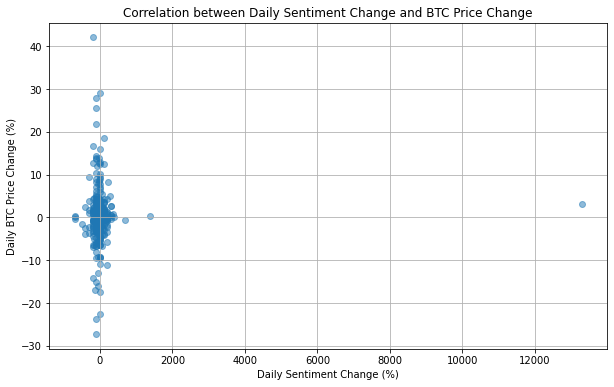

In [0]:
# 1. Define a window ordered by date
window_spec = Window.orderBy("date")

# 2. Compute previous day's net_sentiment and btc_close
joined_df = joined_df.withColumn("net_sentiment_prev", lag("net_sentiment").over(window_spec))
joined_df = joined_df.withColumn("btc_close_prev", lag("btc_close").over(window_spec))

# 3. Calculate daily percentage change for net_sentiment
joined_df = joined_df.withColumn(
    "sentiment_change",
    ((col("net_sentiment") - col("net_sentiment_prev")) / col("net_sentiment_prev")) * 100
)

# 4. Calculate daily percentage change for BTC close price
joined_df = joined_df.withColumn(
    "price_change",
    ((col("btc_close") - col("btc_close_prev")) / col("btc_close_prev")) * 100
)

# 5. Filter out rows where changes are null (e.g. first row has no lag)
joined_df = joined_df.filter(
    col("sentiment_change").isNotNull() & col("price_change").isNotNull()
)

# 6. Convert to Pandas for correlation analysis
joined_pd = joined_df.select("sentiment_change", "price_change").toPandas()

# 7. Compute Pearson correlation
corr_matrix = joined_pd.corr(method="pearson")
print("Correlation matrix:")
print(corr_matrix)

# 8. Scatter plot to visualize the relationship
plt.figure(figsize=(10,6))
plt.scatter(joined_pd["sentiment_change"], joined_pd["price_change"], alpha=0.5)
plt.xlabel("Daily Sentiment Change (%)")
plt.ylabel("Daily BTC Price Change (%)")
plt.title("Correlation between Daily Sentiment Change and BTC Price Change")
plt.grid(True)
plt.show()

There's no correlation between `sentiment_change` and `price_change` and viceversa.